In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
tf.__version__

'2.3.0'

In [67]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
train_images = x_train.reshape(x_train.shape[0],28,28,1).astype("float32")
train_images = train_images/255.0

samples = 128

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).batch(samples)

In [68]:
def get_noise(n_samples,z_dim):
    return tf.random.normal([n_samples,z_dim])

In [69]:
def generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(64,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
      
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model
        

    

In [70]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64,(5,5), strides = (2,2) , padding = "same"  ,input_shape = (28,28,1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Conv2D(128,(5,5), strides = (2,2) , padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1 , activation = "sigmoid" ))
    
    
    return model


In [71]:
gen = generator()
disc = discriminator()
bce = tf.losses.BinaryCrossentropy()

In [72]:
def gen_loss(fake_output):
    
    
    return bce(tf.ones_like(fake_output) , fake_output )
    
    
    
    

def disc_loss(fake_output,real_output):
    
    fake_loss = bce(tf.zeros_like(fake_output),fake_output)
    real_loss = bce(tf.ones_like(real_output),real_output)
    total_loss = (fake_loss + real_loss)
    
    
    
    return total_loss





In [73]:
gen_optimizer = tf.optimizers.Adam(0.002,0.5,0.999)
disc_optimizer = tf.optimizers.Adam(0.0002,0.5,0.999)


In [74]:
epochs = 50
z_dim = 64


In [75]:
@tf.function
def train_step(real_images):
    
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        noise = get_noise(samples,z_dim)
        fake_image = gen(noise , training = True)
        fake_output = disc(fake_image , training = True)
        real_output = disc(real_images , training = True)
    
        ####################################

        g_loss = gen_loss(fake_output)
        d_loss = disc_loss(fake_output,real_output)
        
    gen_grad = gen_tape.gradient(g_loss , gen.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grad,gen.trainable_variables))
        
    disc_grad = disc_tape.gradient(d_loss , disc.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_grad , disc.trainable_variables))
    return g_loss ,d_loss  
        
        
        
    

In [76]:
def train(dataset,epoch):
    mean_gen_loss_list = []
    mean_disc_loss_list = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        for image in dataset:
            
            g_loss, d_loss , = train_step(image)
            
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)
            
        mean_g_loss = sum(gen_loss_list)/len(gen_loss_list)
        mean_d_loss = sum(disc_loss_list)/len(disc_loss_list)
        mean_gen_loss_list.append(mean_g_loss)
        mean_disc_loss_list.append(mean_d_loss)    
            
        print (f'Epoch {epoch+1}, gen loss={mean_g_loss},disc loss={mean_d_loss}')
        
    return mean_gen_loss_list , mean_disc_loss_list    
        

In [77]:
G_loss , D_loss = train(train_dataset,epochs)

Epoch 1, gen loss=0.8266943097114563,disc loss=1.3481650352478027
Epoch 2, gen loss=1.3724207878112793,disc loss=0.7632327675819397
Epoch 3, gen loss=1.6124972105026245,disc loss=0.6658332943916321
Epoch 4, gen loss=1.7789520025253296,disc loss=0.6094807982444763
Epoch 5, gen loss=1.8789514303207397,disc loss=0.5867072343826294
Epoch 6, gen loss=1.9360902309417725,disc loss=0.5781580805778503
Epoch 7, gen loss=1.8794550895690918,disc loss=0.6442098617553711
Epoch 8, gen loss=1.9544802904129028,disc loss=0.5946199893951416
Epoch 9, gen loss=2.040926456451416,disc loss=0.5824657082557678
Epoch 10, gen loss=1.984800934791565,disc loss=0.6254510879516602
Epoch 11, gen loss=2.0101935863494873,disc loss=0.6287686228752136
Epoch 12, gen loss=2.1331357955932617,disc loss=0.5542134642601013
Epoch 13, gen loss=2.100367784500122,disc loss=0.5868800282478333
Epoch 14, gen loss=2.1060097217559814,disc loss=0.5741260647773743
Epoch 15, gen loss=2.295571804046631,disc loss=0.5055147409439087
Epoch 16

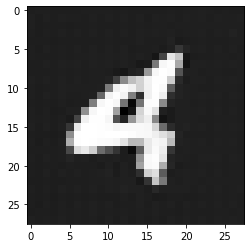

In [78]:
i = (gen(np.random.rand(1,64)).numpy().reshape(28,28) )
plt.imshow(i*255,cmap="gray")

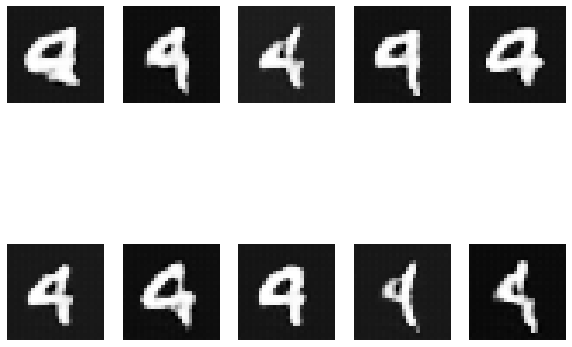

In [79]:
#mode collapse is happening
noises = np.random.rand(10,64)
images = []
for i in range(noises.shape[0]):
    images.append((gen(noises[i].reshape(1,64)).numpy().reshape(28,28))*(255))

fig , ax = plt.subplots(2,5 , figsize = (10,8))

for j in range(2):
  for i in range(5):
    plt.sca(ax[j][i])
    if j == 0:
      plt.imshow(images[i] , cmap = "gray")
    else:
      plt.imshow(images[i+5],cmap = "gray")
    plt.axis("off")
    

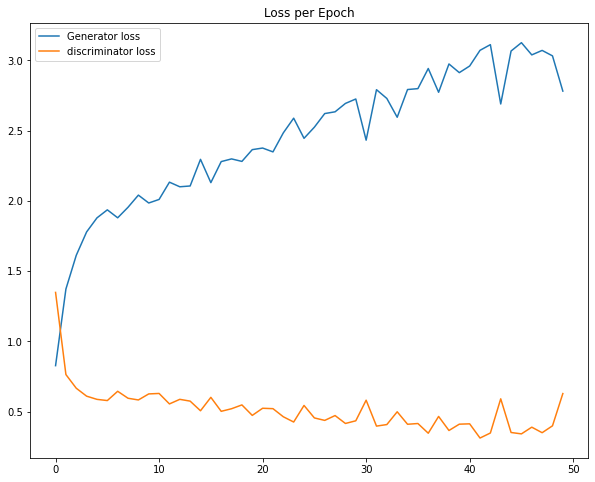

In [83]:
plt.figure(figsize=(10,8))
plt.plot(G_loss , label = "Generator loss" , linewidth = 1.5)
plt.plot(D_loss, label = "discriminator loss" , linewidth = 1.5)
plt.legend()
plt.title("Loss per Epoch")
plt.show()

    
